In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
from os.path import join
import os
import pingouin as pg
from tqdm.notebook import tqdm
import numpy as np
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/MyDrive/1 PhD/OverconfidenceLLM/precision/outputs"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [ ]:
def read_json(data_path):
    with open(data_path, 'r') as file:
        data = json.load(file)
    return data

def write_json(data_path, data):
    with open(data_path, 'w') as f:
        json.dump(data, f)

def read_txt(txt_path):
    f = open(txt_path, "r")
    return f.read()

def write_json_lines(file_name,dict_data):
    json_string = json.dumps(dict_data)
    with open(file_name, 'a') as f:
        f.write(json_string+"\n")

def read_json_lines(file_name):
    lines = []
    with open(file_name) as file_in:
        for line in file_in:
            try:
                lines.append(json.loads(line))
            except:
                continue
    return lines

def save_dict_list(file_name, dicts_data):
    for dict_data in dicts_data:
        write_json_lines(file_name,dict_data)

## Measures

In [ ]:
def upload_data(data_name, model_name, ci_explain, cot):
    file_path = join(DATA_PATH, 'clean|{}|{}|{}|{}.jsonl'.format(data_name, model_name, str(ci_explain), str(cot)))

    data_df = pd.DataFrame(read_json_lines(file_path))
    return data_df

def process_data(df):
    df_ = df.copy()
    df_['lower_bound'] = pd.to_numeric(df_['lower_bound'], errors='coerce') # df_['lower_bound'].astype(float)
    df_['upper_bound'] = pd.to_numeric(df_['upper_bound'], errors='coerce') # df_['upper_bound'].astype(float)
    df_['answer'] = pd.to_numeric(df_['answer'], errors='coerce')# df_['answer'].astype(float)
    df_['length'] = df_['upper_bound'] - df_['lower_bound']
    df_['hit'] = (df_['upper_bound']>= df_['answer']) & (df_['lower_bound'] <= df_['answer'])
    return df_

def get_general_stats(df):
    all_res = {}
    all_hit_pct = df[df['hit']].shape[0]/df.shape[0]
    all_res['all_hits'] = all_hit_pct
    if 'confidence_pct' in list(df.columns):
        for confs in list(df['confidence_pct'].unique()):
            hit_pct = df[df['hit'] & (df['confidence_pct'] == confs)].shape[0]/df[df['confidence_pct'] == confs].shape[0]
            all_res['hits|conf:{}'.format(confs)] = hit_pct
        try:
            corr_res = pg.corr(x=df['confidence_pct'], y=df['length'])
            corr_res = corr_res.to_dict('records')[0]
            corr_res = {'lconf_corr_'+k:v for k, v in corr_res.items() if k in ['n', 'r', 'p-val']}
            all_res.update(corr_res)
        except Exception as e:
            print('STATS ERR: ', e)
    # all_res['len_corr'] = corr_res['r']
    return all_res

def length_vs_scale(df):
    all_res = {}
    all_res['len_scale_corr'] = pg.corr(x=df['answer'], y=df['length'])
    return all_res

def scale_vs_precision(df):
    y1 = df[df['hit']]['answer'] # things that were answered right
    y2 = df[~df['hit']]['answer'] # thigs that were answered wrong
    bins = np.linspace(-20, 20, 50)
    colors = ['b','g']

    #plots the histogram
    fig, ax1 = plt.subplots()
    ax1.hist([y1,y2], bins = bins,color=colors, label=['correct', 'incorrect'])
    plt.legend(loc='upper right')
    ax1.set_xlim(-20,20)
    ax1.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

def length_vs_precision(df):
    y1 = df[df['hit']]['length'] # things that were answered right
    y2 = df[~df['hit']]['length'] # thigs that were answered wrong
    bins = np.linspace(0, 20, 50)
    colors = ['b','g']

    #plots the histogram
    fig, ax1 = plt.subplots()
    ax1.hist([y1,y2], bins = bins,color=colors, label=['correct', 'incorrect'])
    plt.legend(loc='upper right')
    ax1.set_xlim(0,20)
    ax1.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

def aggregate_responses(df, mixed_confidence, strategy):

    df_ = df.copy()
    main_cols = ['lower_bound', 'upper_bound', 'answer']
    if mixed_confidence:
        grp_cols = ['id']
    else:
        grp_cols = ['id', 'confidence_pct']

    if strategy == 'lwm':
        # len_mean = df_.groupby(grp_cols)['length'].expanding().mean().reset_index()
        df_['len_sum'] = df_.groupby(grp_cols)['length'].transform('sum')
        df_['lower_bound'] = (df_['lower_bound']*df_['length'])/df_['len_sum']
        df_['upper_bound'] = (df_['upper_bound']*df_['length'])/df_['len_sum']
    elif strategy == 'ilwm':
        df_['ilength'] = 1.0/df_['length']
        # ilen_mean = df_.groupby(grp_cols)['ilength'].expanding().mean().reset_index()
        df_['ilen_sum'] = df_.groupby(grp_cols)['ilength'].transform('sum')
        df_['lower_bound'] = (df_['lower_bound']*df_['ilength'])/df_['ilen_sum']
        df_['upper_bound'] = (df_['upper_bound']*df_['ilength'])/df_['ilen_sum']
    elif strategy == 'cwm' and mixed_confidence:
        # ilen_mean = df_.groupby(grp_cols)['ilength'].expanding().mean().reset_index()
        df_['conf_sum'] = df_.groupby(grp_cols)['confidence_pct'].transform('sum')
        df_['lower_bound'] = (df_['lower_bound']*df_['confidence_pct'])/df_['conf_sum']
        df_['upper_bound'] = (df_['upper_bound']*df_['confidence_pct'])/df_['conf_sum']

    grps = df_.groupby(grp_cols)
    main_cols = grp_cols + main_cols

    if strategy == 'min_max':
        df_res = grps.agg({"lower_bound": 'min', "upper_bound": 'max', 'answer': 'min'}).reset_index()
        df_res = df_res[main_cols]
    elif strategy == 'mean':
        df_res = grps.agg({"lower_bound": 'mean', "upper_bound": 'mean', 'answer': 'min'}).reset_index()
        df_res = df_res[main_cols]
    elif strategy == 'lwm':# length weighted mean
        # grps['lower_bound'] = (grps['lower_bound'] * grps['length'])/grps['length'].sum()
        df_res = grps.agg({"lower_bound": 'sum', "upper_bound": 'sum', 'answer': 'min'}).reset_index()
        df_res = df_res[main_cols]
    elif strategy == 'ilwm':# inverse length weighted mean
        df_res = grps.agg({"lower_bound": 'sum', "upper_bound": 'sum', 'answer': 'min'}).reset_index()
        df_res = df_res[main_cols]
    elif strategy == 'cwm' and mixed_confidence: # confidence weighted mean
        df_res = grps.agg({"lower_bound": 'sum', "upper_bound": 'sum', 'answer': 'min'}).reset_index()
        df_res = df_res[main_cols]
    else:
        print('Choose the right strategy!')
        return None
    return df_res

def get_all_gen_stats():
    all_data = []
    pbar = tqdm()
    for data_name in tqdm(['finqa', 'mmlu', 'medmcqa_medqa']):
        for cot in tqdm([True, False], leave=False):
            for model_name in tqdm(['gpt-4o-mini', 'gpt-3.5-turbo'], leave=False): #
                data_df = upload_data(data_name = data_name, model_name = model_name, ci_explain = True, cot = cot)
                data_pro_df = process_data(df = data_df)
                for hint in tqdm(list(data_pro_df['hint_type'].unique()), leave=False):
                    for mixed_confidence in tqdm([True, False], leave=False):
                        for agg_strategy in tqdm(['min_max', 'mean', 'lwm', 'ilwm', 'cwm'], leave=False):
                            data_grp = data_pro_df[data_pro_df['hint_type'] == hint]
                            agg_data_df = aggregate_responses(df = data_grp, mixed_confidence = mixed_confidence, strategy = agg_strategy)

                            if agg_data_df is None:
                                print("Combo Doesn't exist")
                                continue
                            agg_data_df = process_data(df = agg_data_df)
                            hint_stats = get_general_stats(agg_data_df)
                            # return hint_stats
                            hint_stats['cot'] = cot
                            hint_stats['data_name'] = data_name
                            hint_stats['hint'] = hint
                            hint_stats['model_name'] = model_name
                            hint_stats['agg_strategy'] = agg_strategy
                            hint_stats['mixed_confidence'] = mixed_confidence
                            all_data.append(hint_stats)
                            pbar.update()
    return pd.DataFrame(all_data)


def get_all_gen_stats_single_precision():
    all_data = []
    pbar = tqdm()
    for data_name in tqdm(['finqa', 'mmlu', 'medmcqa_medqa']):
        for cot in tqdm([False], leave=False):
            for model_name in tqdm(['gpt-4o-mini'], leave=False): # , 'gpt-3.5-turbo'
                data_df = upload_data(data_name = data_name, model_name = model_name, ci_explain = True, cot = cot)
                data_pro_df = process_data(df = data_df)
                for hint in ['hint0']: # tqdm(list(data_pro_df['hint_type'].unique()), leave=False)
                    for mixed_confidence in tqdm([False], leave=False):
                        for agg_strategy in tqdm(['min_max', 'mean', 'lwm', 'ilwm'], leave=False):
                            for agg_count in [3]:
                                for agg_run in tqdm(range(10), leave=False):
                                    data_grp = data_pro_df[data_pro_df['hint_type'] == hint].groupby(['id', 'confidence_pct', 'data_name', 'model_name', 'cot']).sample(agg_count, replace=True)
                                    agg_data_df = aggregate_responses(df = data_grp, mixed_confidence = mixed_confidence, strategy = agg_strategy)

                                    if agg_data_df is None:
                                        print("Combo Doesn't exist")
                                        continue
                                    agg_data_df = process_data(df = agg_data_df)
                                    hint_stats = get_general_stats(agg_data_df)
                                    # return hint_stats
                                    hint_stats['cot'] = cot
                                    hint_stats['data_name'] = data_name
                                    hint_stats['hint'] = hint
                                    hint_stats['model_name'] = model_name
                                    hint_stats['agg_strategy'] = agg_strategy
                                    hint_stats['mixed_confidence'] = mixed_confidence
                                    hint_stats['agg_count'], hint_stats['agg_run'] = agg_count, agg_run
                                    all_data.append(hint_stats)
                                    pbar.update()
    return pd.DataFrame(all_data)

def get_all_gen_stats_mixed_precision():
    all_data = []
    pbar = tqdm()
    for data_name in tqdm(['finqa', 'mmlu', 'medmcqa_medqa']):
        for cot in tqdm([False], leave=False):
            for model_name in tqdm(['gpt-4o-mini'], leave=False): # , 'gpt-3.5-turbo'
                data_df = upload_data(data_name = data_name, model_name = model_name, ci_explain = True, cot = cot)
                data_pro_df = process_data(df = data_df)

                for hint in ['hint0']: # tqdm(list(data_pro_df['hint_type'].unique()), leave=False)
                    for mixed_confidence in tqdm([True], leave=False):
                        for agg_strategy in tqdm(['min_max', 'mean', 'lwm', 'ilwm', "cwm"], leave=False):
                            for agg_count in [3]:
                                for agg_run in tqdm(range(10), leave=False):
                                    data_grp = data_pro_df[data_pro_df['hint_type'] == hint].groupby(['id', 'confidence_pct', 'data_name', 'model_name', 'cot']).sample(agg_count, replace=True)
                                    agg_data_df = aggregate_responses(df = data_grp, mixed_confidence = mixed_confidence, strategy = agg_strategy)

                                    if agg_data_df is None:
                                        print("Combo Doesn't exist")
                                        continue
                                    agg_data_df = process_data(df = agg_data_df)
                                    hint_stats = get_general_stats(agg_data_df)
                                    # return hint_stats
                                    hint_stats['cot'] = cot
                                    hint_stats['data_name'] = data_name
                                    hint_stats['hint'] = hint
                                    hint_stats['model_name'] = model_name
                                    hint_stats['agg_strategy'] = agg_strategy
                                    hint_stats['mixed_confidence'] = mixed_confidence
                                    hint_stats['agg_count'], hint_stats['agg_run'] = agg_count, agg_run
                                    all_data.append(hint_stats)
                                    pbar.update()
    return pd.DataFrame(all_data)

def format_final_results(res_df):
    fin_res = res_df[res_df['hint'] =='hint0'].groupby(['data_name', 'model_name', 'cot', 'agg_strategy',  'mixed_confidence']).first()
    subset_fin_res = res_df[(res_df['model_name'] == 'gpt-4o-mini') & (res_df['mixed_confidence'] == False)& (res_df['cot'] == False)]
    subset_fin_res = subset_fin_res[subset_fin_res['hint'] =='hint0'].groupby(['data_name', 'model_name', 'cot', 'agg_strategy',  'mixed_confidence']).first()
    print('before groupby: ', res_df[res_df['hint'] =='hint0'].shape[0])
    print('after groupby: ', fin_res.shape[0])
    # fin_res = res_df[res_df['hint'] =='hint0'].groupby(['data_name', 'model_name', 'cot']).agg({
    #     "all_hits": [np.mean, np.std], "hits|conf:95": [np.mean, np.std], "hits|conf:90": [np.mean, np.std], "hits|conf:60": [np.mean, np.std],
    #     "hits|conf:70": [np.mean, np.std], "hits|conf:80": [np.mean, np.std], "lconf_corr_n": np.mean, "lconf_corr_r": [np.mean, np.std],
    #     "lconf_corr_p-val": [np.mean, np.std], "num_count": np.mean, "nona_num_count": np.mean
    # })
    return fin_res, subset_fin_res

def process_results_nomixing(res_df):
    col_map = {
        "all_hits": 'hit-avg', 'hits|conf:95': 'hit@95%', 'hits|conf:90': 'hit@90%',
        'hits|conf:60': 'hit@60%', 'hits|conf:70': 'hit@70%', 'hits|conf:80': 'hit@80%',
        'lconf_corr_r': 'corr', 'hint': 'hint', 'data_name': 'dataset', 'model_name': 'model',
        'agg_strategy': 'agg_strategy'
    }# ,  'mixed_confidence': "mixed_confidence" 'cot': 'cot',
    agg_strategy_map = {
        'ilwm': 'iLWM',
        'lwm': 'LWM',
        'mean': 'MIA',
        'min_max': 'Union',
        'cwa': 'CWA'
    }
    res_df = res_df[list(col_map.keys())]
    res_df = res_df.rename(columns= col_map)
    res_df['agg_strategy'] = res_df['agg_strategy'].map(agg_strategy_map)
    fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'agg_strategy']).agg({
        "hit-avg": [np.mean, np.std], "hit@95%": [np.mean, np.std], "hit@90%": [np.mean, np.std], "hit@60%": [np.mean, np.std],
        "hit@70%": [np.mean, np.std], "hit@80%": [np.mean, np.std], "corr": [np.mean, np.std]
    })
    def use_f_2(num_decimals):
        def use_f_2_(x):
            return f"%.{num_decimals}f" % x
        return use_f_2_

    latex_format = {}

    for col in list(fin_res.columns):
        if 'hit' in col[0]:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))*100
            latex_format[col] = use_f_2(num_decimals = 2)
        else:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))
            latex_format[col] = use_f_2(num_decimals = 4)
    fin_res_latex = fin_res.to_latex(formatters=latex_format)
    return fin_res, fin_res_latex

def process_results_mixing(res_df_):
    res_df = res_df_.copy()
    col_map = {
        "all_hits": 'hit-avg',
        'hint': 'hint', 'data_name': 'dataset', 'model_name': 'model',
        'agg_strategy': 'agg_strategy'
    }# ,  'mixed_confidence': "mixed_confidence" 'cot': 'cot',
    agg_strategy_map = {
        'ilwm': 'iLWM',
        'lwm': 'LWM',
        'mean': 'MIA',
        'min_max': 'Union',
        'cwm': 'CWA'
    }
    res_df = res_df[list(col_map.keys())]
    res_df = res_df.rename(columns= col_map)
    res_df['agg_strategy'] = res_df['agg_strategy'].map(agg_strategy_map)
    fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'agg_strategy']).agg({
        "hit-avg": [np.mean, np.std]
    })
    def use_f_2(num_decimals):
        def use_f_2_(x):
            return f"%.{num_decimals}f" % x
        return use_f_2_

    latex_format = {}

    for col in list(fin_res.columns):
        if 'hit' in col[0]:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))*100
            latex_format[col] = use_f_2(num_decimals = 2)
        else:
            fin_res[col] = fin_res[col].apply(lambda x: round(x, 4))
            latex_format[col] = use_f_2(num_decimals = 4)
    res_form_mix_df_k = pd.pivot_table(fin_res.reset_index(), values=[('hit-avg', 'mean'), ('hit-avg', 'std')], index=['dataset', 'model'], columns=['agg_strategy'], aggfunc="sum")
    res_form_mix_df_k.columns = res_form_mix_df_k.columns.swaplevel(0, 1)
    res_form_mix_df_k.columns = res_form_mix_df_k.columns.swaplevel(0, 1)
    res_form_mix_df_k.columns = res_form_mix_df_k.columns.swaplevel(0, 1)
    res_form_mix_df_k.columns = res_form_mix_df_k.columns.swaplevel(0, 2)
    res_form_mix_df_k = res_form_mix_df_k.sort_index(axis=1, level=0)
    res_form_mix_df_k = res_form_mix_df_k.droplevel(1, axis = 1)
    res_form_mix_df_k = res_form_mix_df_k.droplevel(1, axis = 0)
    res_form_mix_df_k_latex = res_form_mix_df_k.to_latex(float_format="%.2f")
    # res_form_mix_df_k_latex = res_form_mix_df_k.to_latex()
    return res_form_mix_df_k, res_form_mix_df_k_latex


## General Stats

In [ ]:
all_stats = get_all_gen_stats()

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4788: RuntimeWarning: invalid value encountered in subtract
  ym = y.astype(dtype) - ymean


STATS ERR:  array must not contain infs or NaNs
Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Choose the right strategy!
Combo Doesn't exist


In [ ]:
all_res, mini_res = format_final_results(res_df = all_stats)

before groupby:  108
after groupby:  108


In [ ]:
display(HTML(mini_res.to_html()))

In [ ]:
display(vv)

all_hits   hint  \
data_name agg_strategy model_name    cot   mixed_confidence                    
finqa     cwm          gpt-3.5-turbo False True              0.067750  hint0   
                                     True  True              0.098712  hint0   
                       gpt-4o-mini   False True              0.195586  hint0   
                                     True  True              0.210300  hint0   
          ilwm         gpt-3.5-turbo False False             0.064807  hint0   
...                                                               ...    ...   
mmlu      min_max      gpt-3.5-turbo True  True              0.948941  hint0   
                       gpt-4o-mini   False False             0.806227  hint0   
                                           True              0.867995  hint0   
                                     True  False             0.924658  hint0   
                                           True              0.963885  hint0   

                                                             hits|conf:60  \
data_name agg_strategy model_name    cot   mixed_confidence                 
finqa     cwm          gpt-3.5-turbo False True                       NaN   
                                     True  True                       NaN   
                       gpt-4o-mini   False True                       NaN   
                                     True  True                       NaN   
          ilwm         gpt-3.5-turbo False False                 0.072961   
...                                                                   ...   
mmlu      min_max      gpt-3.5-turbo True  True                       NaN   
                       gpt-4o-mini   False False                 0.805729   
                                           True                       NaN   
                                     True  False                 0.920299   
                                           True                       NaN   

                                                             hits|conf:70  \
data_name agg_strategy model_name    cot   mixed_confidence                 
finqa     cwm          gpt-3.5-turbo False True                       NaN   
                                     True  True                       NaN   
                       gpt-4o-mini   False True                       NaN   
                                     True  True                       NaN   
          ilwm         gpt-3.5-turbo False False                 0.071429   
...                                                                   ...   
mmlu      min_max      gpt-3.5-turbo True  True                       NaN   
                       gpt-4o-mini   False False                 0.802615   
                                           True                       NaN   
                                     True  False                 0.925903   
                                           True                       NaN   

                                                             hits|conf:80  \
data_name agg_strategy model_name    cot   mixed_confidence                 
finqa     cwm          gpt-3.5-turbo False True                       NaN   
                                     True  True                       NaN   
                       gpt-4o-mini   False True                       NaN   
                                     True  True                       NaN   
          ilwm         gpt-3.5-turbo False False                 0.062232   
...                                                                   ...   
mmlu      min_max      gpt-3.5-turbo True  True                       NaN   
                       gpt-4o-mini   False False                 0.806351   
                                           True                       NaN   
                                     True  False                 0.920922   
                                           True                       NaN   

              

### Single precision

In [ ]:
single_pres_stats = get_all_gen_stats_single_precision()

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
res_form_df, res_form_tex = process_results_nomixing(res_df = single_pres_stats)

<ipython-input-125-765718ef82ff>:246: FutureWarning: The provided callable <function mean at 0x792fadc2ce00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'agg_strategy']).agg({
<ipython-input-125-765718ef82ff>:246: FutureWarning: The provided callable <function std at 0x792fadc2cf40> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'agg_strategy']).agg({
<ipython-input-125-765718ef82ff>:246: FutureWarning: The provided callable <function mean at 0x792fadc2ce00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavio

In [ ]:
print(res_form_tex)

\begin{tabular}{lllrrrrrrrrrrrrrr}
\toprule
 &  &  & \multicolumn{2}{r}{hit-avg} & \multicolumn{2}{r}{hit@95%} & \multicolumn{2}{r}{hit@90%} & \multicolumn{2}{r}{hit@60%} & \multicolumn{2}{r}{hit@70%} & \multicolumn{2}{r}{hit@80%} & \multicolumn{2}{r}{corr} \\
 &  &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
dataset & model & agg_strategy &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{finqa} & \multirow[t]{4}{*}{gpt-4o-mini} & LWM & 19.46 & 0.17 & 22.58 & 0.41 & 20.48 & 0.49 & 17.99 & 0.42 & 16.88 & 0.36 & 19.36 & 0.35 & -0.0013 & 0.0028 \\
 &  & MIA & 18.74 & 0.14 & 21.84 & 0.34 & 19.44 & 0.26 & 17.09 & 0.39 & 16.49 & 0.32 & 18.87 & 0.36 & -0.0024 & 0.0022 \\
 &  & Union & 33.88 & 0.16 & 35.87 & 0.48 & 34.54 & 0.38 & 32.64 & 0.32 & 31.89 & 0.33 & 34.44 & 0.28 & 0.0013 & 0.0021 \\
 &  & iLWM & 17.01 & 0.19 & 19.29 & 0.28 & 17.71 & 0.52 & 15.83 & 0.36 & 15.17 & 0.44 & 17.05 & 0.38 & -0.0051 & 0.0018 \\
\cline{

### Mixed precision

In [ ]:
mixed_pres_stats = get_all_gen_stats_mixed_precision()

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
mixed_pres_stats

,all_hits,cot,data_name,hint,model_name,agg_strategy,mixed_confidence,agg_count,agg_run
0,0.545371,False,finqa,hint0,gpt-4o-mini,min_max,True,3,0
1,0.556407,False,finqa,hint0,gpt-4o-mini,min_max,True,3,1
2,0.546597,False,finqa,hint0,gpt-4o-mini,min_max,True,3,2
3,0.553342,False,finqa,hint0,gpt-4o-mini,min_max,True,3,3
4,0.552115,False,finqa,hint0,gpt-4o-mini,min_max,True,3,4
...,...,...,...,...,...,...,...,...,...
145,0.523810,False,medmcqa_medqa,hint0,gpt-4o-mini,cwm,True,3,5
146,0.535471,False,medmcqa_medqa,hint0,gpt-4o-mini,cwm,True,3,6
147,0.528183,False,medmcqa_medqa,hint0,gpt-4o-mini,cwm,True,3,7
148,0.533528,False,medmcqa_medqa,hint0,gpt-4o-mini,cwm,True,3,8


In [ ]:
res_form_mix_df, res_form_mix_tex = process_results_mixing(res_df_ = mixed_pres_stats)

<ipython-input-139-f230899d9562>:284: FutureWarning: The provided callable <function mean at 0x792fadc2ce00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'agg_strategy']).agg({
<ipython-input-139-f230899d9562>:284: FutureWarning: The provided callable <function std at 0x792fadc2cf40> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  fin_res = res_df[res_df['hint'] =='hint0'].groupby(['dataset', 'model', 'agg_strategy']).agg({
<ipython-input-139-f230899d9562>:301: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  res_form_mix_df_k = pd.pivot_table(fin_res.reset_index(), values=[('hit-avg', 'mean'), ('hit-avg'

In [ ]:
res_form_mix_df

agg_strategy     CWA          LWM          MIA        Union         iLWM      
                mean   std   mean   std   mean   std   mean   std   mean   std
dataset                                                                       
finqa          19.58  0.37  21.47  0.34  19.23  0.28  55.04  0.38  16.02  0.27
medmcqa_medqa  52.84  0.48  54.90  0.43  53.18  0.42  81.78  0.18  44.88  0.39
mmlu           61.19  0.45  62.31  0.43  61.75  0.48  84.62  0.28  33.89  0.45

In [ ]:
print(res_form_mix_tex)

\begin{tabular}{lrrrrrrrrrr}
\toprule
agg_strategy & \multicolumn{2}{r}{CWA} & \multicolumn{2}{r}{LWM} & \multicolumn{2}{r}{MIA} & \multicolumn{2}{r}{Union} & \multicolumn{2}{r}{iLWM} \\
 & mean & std & mean & std & mean & std & mean & std & mean & std \\
dataset &  &  &  &  &  &  &  &  &  &  \\
\midrule
finqa & 19.58 & 0.37 & 21.47 & 0.34 & 19.23 & 0.28 & 55.04 & 0.38 & 16.02 & 0.27 \\
medmcqa_medqa & 52.84 & 0.48 & 54.90 & 0.43 & 53.18 & 0.42 & 81.78 & 0.18 & 44.88 & 0.39 \\
mmlu & 61.19 & 0.45 & 62.31 & 0.43 & 61.75 & 0.48 & 84.62 & 0.28 & 33.89 & 0.45 \\
\bottomrule
\end{tabular}



In [ ]:
xx = pd.pivot_table(res_form_mix_df.reset_index(), values=[('hit-avg', 'mean'), ('hit-avg', 'std')], index=['dataset', 'model'], columns=['agg_strategy'], aggfunc="sum")

<ipython-input-110-469568f887ae>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  xx = pd.pivot_table(res_form_mix_df.reset_index(), values=[('hit-avg', 'mean'), ('hit-avg', 'std')], index=['dataset', 'model'], columns=['agg_strategy'], aggfunc="sum")


In [ ]:
xx.columns = xx.columns.swaplevel(0, 1)
xx.columns = xx.columns.swaplevel(0, 1)
xx.columns = xx.columns.swaplevel(0, 1)

In [ ]:
xx.columns = xx.columns.swaplevel(0, 2)


In [ ]:
xx.sort_index(axis=1, level=0)

agg_strategy                  CWA           LWM           MIA         Union  \
                          hit-avg       hit-avg       hit-avg       hit-avg   
                             mean   std    mean   std    mean   std    mean   
dataset       model                                                           
finqa         gpt-4o-mini   19.64  0.26   21.09  0.26   19.27  0.34   55.26   
medmcqa_medqa gpt-4o-mini   52.92  0.37   54.91  0.47   53.21  0.22   81.78   
mmlu          gpt-4o-mini   61.33  0.42   62.30  0.40   61.63  0.32   84.60   

agg_strategy                       iLWM        
                                hit-avg        
                            std    mean   std  
dataset       model                            
finqa         gpt-4o-mini  0.35   15.70  0.29  
medmcqa_medqa gpt-4o-mini  0.36   44.76  0.27  
mmlu          gpt-4o-mini  0.27   34.05  0.59

In [ ]:
xx[ppp]

KeyError: "None of [MultiIndex([('hit-avg',   'CWA', 'mean'),\n            ('hit-avg',   'LWM', 'mean'),\n            ('hit-avg',   'MIA', 'mean'),\n            ('hit-avg', 'Union', 'mean'),\n            ('hit-avg',  'iLWM', 'mean'),\n            ('hit-avg',   'CWA',  'std'),\n            ('hit-avg',   'LWM',  'std'),\n            ('hit-avg',   'MIA',  'std'),\n            ('hit-avg', 'Union',  'std'),\n            ('hit-avg',  'iLWM',  'std')],\n           names=[None, None, 'agg_strategy'])] are in the [columns]"

In [ ]:
xx.columns

MultiIndex([('hit-avg', 'mean',   'CWA'),
            ('hit-avg', 'mean',   'LWM'),
            ('hit-avg', 'mean',   'MIA'),
            ('hit-avg', 'mean', 'Union'),
            ('hit-avg', 'mean',  'iLWM'),
            ('hit-avg',  'std',   'CWA'),
            ('hit-avg',  'std',   'LWM'),
            ('hit-avg',  'std',   'MIA'),
            ('hit-avg',  'std', 'Union'),
            ('hit-avg',  'std',  'iLWM')],
           names=[None, None, 'agg_strategy'])

In [ ]:
res_form_mix_df.reset_index()

dataset        model agg_strategy hit-avg      
                                               mean   std
0           finqa  gpt-4o-mini          CWA   19.64  0.26
1           finqa  gpt-4o-mini          LWM   21.09  0.26
2           finqa  gpt-4o-mini          MIA   19.27  0.34
3           finqa  gpt-4o-mini        Union   55.26  0.35
4           finqa  gpt-4o-mini         iLWM   15.70  0.29
5   medmcqa_medqa  gpt-4o-mini          CWA   52.92  0.37
6   medmcqa_medqa  gpt-4o-mini          LWM   54.91  0.47
7   medmcqa_medqa  gpt-4o-mini          MIA   53.21  0.22
8   medmcqa_medqa  gpt-4o-mini        Union   81.78  0.36
9   medmcqa_medqa  gpt-4o-mini         iLWM   44.76  0.27
10           mmlu  gpt-4o-mini          CWA   61.33  0.42
11           mmlu  gpt-4o-mini          LWM   62.30  0.40
12           mmlu  gpt-4o-mini          MIA   61.63  0.32
13           mmlu  gpt-4o-mini        Union   84.60  0.27
14           mmlu  gpt-4o-mini         iLWM   34.05  0.59

### Self refinement

In [ ]:
def get_selfrefine_data(data_name, model_name, ci_exaplain, cot, mixed_confidence, n_spies):
    data_path = join(DATA_PATH, 'selfrefine|{}|{}|{}|{}|{}|{}.jsonl'.format(
        data_name, model_name, str(ci_exaplain), str(cot), str(mixed_confidence), str(n_spies)
    ))
    data_df = pd.DataFrame(read_json_lines(data_path))
    return data_df


def selfrefine_results_single_confidence(horizon = 3):
    chosen_res = []
    proposed_res = []
    for data_name in ['finqa', 'medmcqa_medqa', 'mmlu']:
        for model_name in ['gpt-4o-mini']:
            for ci_exaplain in [True]:
                for cot in [False]:
                    for mixed_confidence in [False]:
                        for n_spies in [horizon]:
                            data = get_selfrefine_data(data_name, model_name, ci_exaplain, cot, mixed_confidence, n_spies)
                            # return data
                            # if horizon > 1:
                            data['chosen_answer_len'] = [len(i) if isinstance(i, list) else 0 for i in list(data['chosen_answer'])]
                            data['proposed_answer_len'] = [len(i) if isinstance(i, list) else 0 for i in list(data['proposed_answer'])]
                            data['confidence_pct'] = [i[0] for i in list(data['confidence_pct'])]
                            # return data
                            data = data[(data['chosen_answer_len']==2) & (data['proposed_answer_len']==2)]

                            data_chosen = data.copy()
                            data_proposed = data.copy()
                            data_chosen[['lower_bound','upper_bound']] = pd.DataFrame(data['chosen_answer'].tolist(), index=data_chosen.index)
                            # return data
                            data_proposed[['lower_bound','upper_bound']] = pd.DataFrame(data['proposed_answer'].tolist(), index=data_proposed.index)

                            data_chosen['id'], data_proposed['id'] = data['id'], data['id']
                            data_chosen['answer'], data_proposed['answer'] = data['answer'], data['answer']
                            data_chosen['confidence_pct'], data_proposed['confidence_pct'] = data['confidence_pct'], data['confidence_pct']
                            data_chosen['conf_prompt_type'], data_proposed['conf_prompt_type'] = data['conf_prompt_type'], data['conf_prompt_type']
                            data_chosen['hint_type'], data_proposed['hint_type'] = data['hint_type'], data['hint_type']
                            data_chosen['data_name'], data_proposed['data_name'] = data['data_name'], data['data_name']
                            data_chosen['model_name'], data_proposed['model_name'] = data['model_name'], data['model_name']
                            data_chosen['ci_exaplain'], data_proposed['ci_exaplain'] = data['ci_exaplain'], data['ci_exaplain']
                            data_chosen['cot'], data_proposed['cot'] = data['cot'], data['cot']

                            # return data_chosen
                            data_chosen_pro_df = process_data(df = data_chosen)
                            data_proposed_pro_df = process_data(df = data_proposed)
                            # return data_chosen_pro_df
                            chosen_stats = get_general_stats(data_chosen_pro_df)
                            proposed_stats = get_general_stats(data_proposed_pro_df)
                            chosen_stats['kind'], proposed_stats['kind'] = 'chosen', 'proposed'
                            chosen_stats['data_name'], proposed_stats['data_name'] = data_name, data_name
                            # chosen_stats['model_name'], proposed_stats['model_name'] = model_name, model_name
                            chosen_res.append(chosen_stats)
                            proposed_res.append(proposed_stats)
    return pd.DataFrame(chosen_res), pd.DataFrame(proposed_res)

def selfrefine_results_mix_confidence(horizon = 9):
    chosen_res = []
    proposed_res = []
    for data_name in ['finqa', 'medmcqa_medqa', 'mmlu']:
        for model_name in ['gpt-4o-mini']:
            for ci_exaplain in [True]:
                for cot in [False]:
                    for mixed_confidence in [True]:
                        for n_spies in [horizon]:
                            data = get_selfrefine_data(data_name, model_name, ci_exaplain, cot, mixed_confidence, n_spies)
                            # return data
                            data['chosen_answer_len'] = [len(i) for i in list(data['chosen_answer'])]
                            data['proposed_answer_len'] = [len(i) for i in list(data['proposed_answer'])]
                            del data['confidence_pct']
                            # data['confidence_pct'] = [i[0] for i in list(data['confidence_pct'])]
                            # return data
                            data = data[(data['chosen_answer_len']==2) & (data['proposed_answer_len']==2)]

                            data_chosen = data.copy()
                            data_proposed = data.copy()
                            data_chosen[['lower_bound','upper_bound']] = pd.DataFrame(data['chosen_answer'].tolist(), index=data_chosen.index)
                            # return data
                            data_proposed[['lower_bound','upper_bound']] = pd.DataFrame(data['proposed_answer'].tolist(), index=data_proposed.index)

                            data_chosen['id'], data_proposed['id'] = data['id'], data['id']
                            data_chosen['answer'], data_proposed['answer'] = data['answer'], data['answer']
                            # data_chosen['confidence_pct'], data_proposed['confidence_pct'] = data['confidence_pct'], data['confidence_pct']
                            data_chosen['conf_prompt_type'], data_proposed['conf_prompt_type'] = data['conf_prompt_type'], data['conf_prompt_type']
                            data_chosen['hint_type'], data_proposed['hint_type'] = data['hint_type'], data['hint_type']
                            data_chosen['data_name'], data_proposed['data_name'] = data['data_name'], data['data_name']
                            data_chosen['model_name'], data_proposed['model_name'] = data['model_name'], data['model_name']
                            data_chosen['ci_exaplain'], data_proposed['ci_exaplain'] = data['ci_exaplain'], data['ci_exaplain']
                            data_chosen['cot'], data_proposed['cot'] = data['cot'], data['cot']

                            # return data_chosen
                            data_chosen_pro_df = process_data(df = data_chosen)
                            data_proposed_pro_df = process_data(df = data_proposed)
                            # return data_chosen_pro_df
                            chosen_stats = get_general_stats(data_chosen_pro_df)
                            proposed_stats = get_general_stats(data_proposed_pro_df)
                            chosen_stats['kind'], proposed_stats['kind'] = 'chosen', 'proposed'
                            chosen_stats['data_name'], proposed_stats['data_name'] = data_name, data_name
                            # chosen_stats['model_name'], proposed_stats['model_name'] = model_name, model_name
                            chosen_res.append(chosen_stats)
                            proposed_res.append(proposed_stats)
    return pd.DataFrame(chosen_res), pd.DataFrame(proposed_res)

def results_extract_self_single(proposed_df, chosen_df):
    col_map = {
        "all_hits": 'hit-avg', 'hits|conf:95': 'hit@95%', 'hits|conf:90': 'hit@90%',
        'hits|conf:60': 'hit@60%', 'hits|conf:70': 'hit@70%', 'hits|conf:80': 'hit@80%',
        'lconf_corr_r': 'corr', 'data_name': 'dataset', 'kind': 'kind'
    }
    all_df = pd.concat([proposed_df, chosen_df])
    all_df = all_df[list(col_map.keys())]
    all_df = all_df.rename(columns = col_map)
    all_df = all_df.groupby(["dataset", "kind"]).first()



    latex_format = {}

    def use_f_2(num_decimals):
        def use_f_2_(x):
            return f"%.{num_decimals}f" % x
        return use_f_2_

    for col in list(all_df.columns):
        if 'hit' in col:
            all_df[col] = all_df[col].apply(lambda x: round(x, 4))*100
            latex_format[col] = use_f_2(num_decimals = 2)
        else:
            all_df[col] = all_df[col].apply(lambda x: round(x, 4))
            latex_format[col] = use_f_2(num_decimals = 4)
    fin_res_latex = all_df.to_latex(formatters=latex_format)
    return all_df, fin_res_latex

def res_extract_self_mix(proposed_df, chosen_df):
    col_map = {
        "all_hits": 'hit-avg', 'data_name': 'dataset', 'kind': 'kind'

    }
    all_df = pd.concat([proposed_df, chosen_df])
    all_df = all_df[list(col_map.keys())]
    all_df = all_df.rename(columns = col_map)
    all_df = all_df.groupby(["dataset", "kind"]).first()

    latex_format = {}

    def use_f_2(num_decimals):
        def use_f_2_(x):
            return f"%.{num_decimals}f" % x
        return use_f_2_

    for col in list(all_df.columns):
        if 'hit' in col:
            all_df[col] = all_df[col].apply(lambda x: round(x, 4))*100
            latex_format[col] = use_f_2(num_decimals = 2)
        else:
            all_df[col] = all_df[col].apply(lambda x: round(x, 4))
            latex_format[col] = use_f_2(num_decimals = 4)
    fin_res_latex = all_df.to_latex(formatters=latex_format)
    return all_df, fin_res_latex

### Single confidence

In [ ]:
# xx = selfrefine_results_single_confidence()
chosen_res_df, proposed_res_df = selfrefine_results_single_confidence()
#

In [ ]:
chosen_res_df

,all_hits,hits|conf:70,hits|conf:95,hits|conf:80,hits|conf:90,hits|conf:60,lconf_corr_n,lconf_corr_r,lconf_corr_p-val,kind,data_name
0,0.180814,0.163340,0.205648,0.177301,0.184219,0.173566,16293,-0.017036,0.029667,chosen,finqa
1,0.606376,0.608358,0.595238,0.610598,0.606900,0.610787,10289,0.019066,0.053122,chosen,medmcqa_medqa
2,0.675056,0.670823,0.667290,0.681196,0.669159,0.686800,8026,0.002069,0.852964,chosen,mmlu


In [ ]:
single_res_df, single_res_tex = results_extract_self_single(proposed_df = proposed_res_df, chosen_df = chosen_res_df)

In [ ]:
single_res_df

hit-avg  hit@95%  hit@90%  hit@60%  hit@70%  hit@80%  \
dataset       kind                                                             
finqa         chosen      18.08    20.56    18.42    17.36    16.33    17.73   
              proposed    14.88    16.91    15.75    13.46    13.26    15.00   
medmcqa_medqa chosen      60.64    59.52    60.69    61.08    60.84    61.06   
              proposed    51.04    50.19    52.43    50.39    50.73    51.48   
mmlu          chosen      67.51    66.73    66.92    68.68    67.08    68.12   
              proposed    58.86    59.75    58.13    57.78    58.85    59.78   

                          corr  
dataset       kind              
finqa         chosen   -0.0170  
              proposed -0.0104  
medmcqa_medqa chosen    0.0191  
              proposed  0.0062  
mmlu          chosen    0.0021  
              proposed  0.0030

In [ ]:
print(single_res_tex)

\begin{tabular}{llrrrrrrr}
\toprule
 &  & hit-avg & hit@95% & hit@90% & hit@60% & hit@70% & hit@80% & corr \\
dataset & kind &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{finqa} & chosen & 18.08 & 20.56 & 18.42 & 17.36 & 16.33 & 17.73 & -0.0170 \\
 & proposed & 14.88 & 16.91 & 15.75 & 13.46 & 13.26 & 15.00 & -0.0104 \\
\cline{1-9}
\multirow[t]{2}{*}{medmcqa_medqa} & chosen & 60.64 & 59.52 & 60.69 & 61.08 & 60.84 & 61.06 & 0.0191 \\
 & proposed & 51.04 & 50.19 & 52.43 & 50.39 & 50.73 & 51.48 & 0.0062 \\
\cline{1-9}
\multirow[t]{2}{*}{mmlu} & chosen & 67.51 & 66.73 & 66.92 & 68.68 & 67.08 & 68.12 & 0.0021 \\
 & proposed & 58.86 & 59.75 & 58.13 & 57.78 & 58.85 & 59.78 & 0.0030 \\
\cline{1-9}
\bottomrule
\end{tabular}



### Mixed confidence

In [ ]:
mix_chosen_res_df, mix_proposed_res_df = selfrefine_results_mix_confidence()

In [ ]:
# single_res_df, single_res_tex = results_extract(proposed_df = mix_proposed_res_df, chosen_df = mix_chosen_res_df)

In [ ]:
mix_res_df, mix_res_tex = res_extract_self_mix(proposed_df = mix_proposed_res_df, chosen_df = mix_chosen_res_df)

In [ ]:
mix_res_df

hit-avg
dataset       kind             
finqa         chosen      18.54
              proposed    15.56
medmcqa_medqa chosen      60.59
              proposed    52.96
mmlu          chosen      65.61
              proposed    59.13

In [ ]:
print(mix_res_tex)

\begin{tabular}{llr}
\toprule
 &  & hit-avg \\
dataset & kind &  \\
\midrule
\multirow[t]{2}{*}{finqa} & chosen & 18.54 \\
 & proposed & 15.56 \\
\cline{1-3}
\multirow[t]{2}{*}{medmcqa_medqa} & chosen & 60.59 \\
 & proposed & 52.96 \\
\cline{1-3}
\multirow[t]{2}{*}{mmlu} & chosen & 65.61 \\
 & proposed & 59.13 \\
\cline{1-3}
\bottomrule
\end{tabular}



In [ ]:
# mix_proposed_res_df

,all_hits,kind,data_name
0,0.147989,proposed,finqa
1,0.523324,proposed,medmcqa_medqa
2,0.571963,proposed,mmlu


## Plot Evolution depending on the number of examples

In [ ]:
def get_all_selfref_horizons_single():
    all_df = []
    for ii in [1, 2, 3, 4]:
        chosen_res_df, proposed_res_df = selfrefine_results_single_confidence(ii)
        single_res_df, single_res_tex = results_extract_self_single(proposed_df = proposed_res_df, chosen_df = chosen_res_df)
        single_res_df['n_examples'] = ii
        single_res_df = single_res_df.reset_index()
        all_df.append(single_res_df)
    all_df = pd.concat(all_df)
    return all_df

def get_all_selfref_horizons_mixed():
    all_df = []
    for ii in [1, 2, 5, 7, 9]:
        chosen_res_df, proposed_res_df = selfrefine_results_mix_confidence(ii)
        single_res_df, single_res_tex = res_extract_self_mix(proposed_df = proposed_res_df, chosen_df = chosen_res_df)
        single_res_df['n_examples'] = ii
        single_res_df = single_res_df.reset_index()
        all_df.append(single_res_df)
    all_df = pd.concat(all_df)
    return all_df


def plot_selfref_horizons(data_df, prefix, save_path):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    plt.figure()
    plt.rcParams.update({'font.size': 18}) # must set in top
    for dataset in list(data_df['dataset'].unique()):
        for kind in list(data_df['kind'].unique()):
            plt_data = data_df[(data_df['dataset'] == dataset) & (data_df['kind'] == kind)]
            # return plt_data
            ax = plt_data[['hit-avg', 'n_examples']].plot(kind= 'line', x = 'n_examples', y = 'hit-avg', color="red")
            save_path_ = join(save_path, "{}|{}|{}.pdf".format(prefix, dataset, kind))
            ax.get_figure().tight_layout()
            ax.get_figure().savefig(save_path_)
            #  ,  title="{}|{}".format(dataset, kind))

In [ ]:
FIGURES_SAVE_PATH = join(DATA_PATH, 'selfref_evolution')

### Single setting

In [ ]:
df_hor_single = get_all_selfref_horizons_single()

In [ ]:
# df_hor_single

<Figure size 640x480 with 0 Axes>

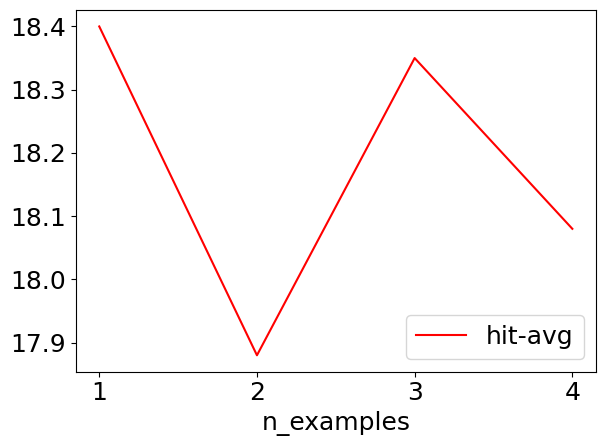

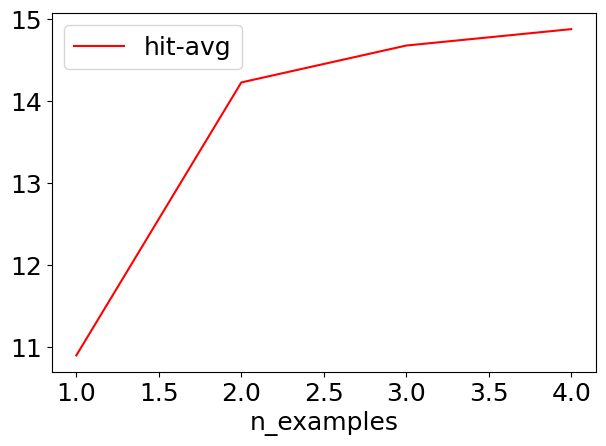

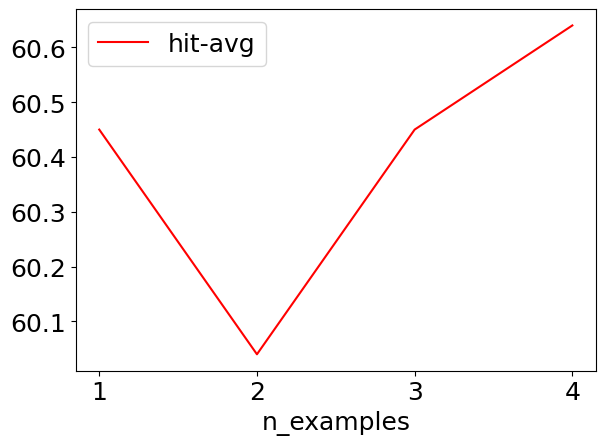

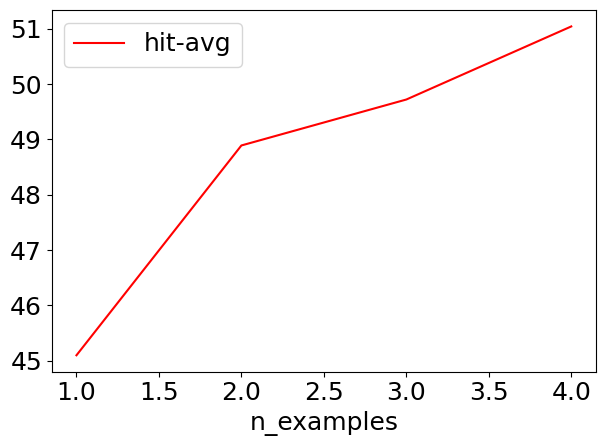

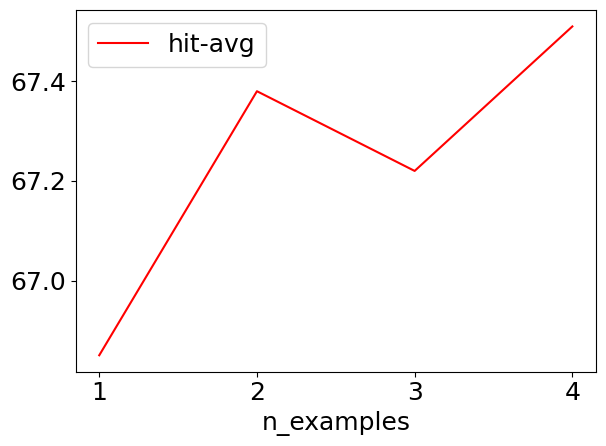

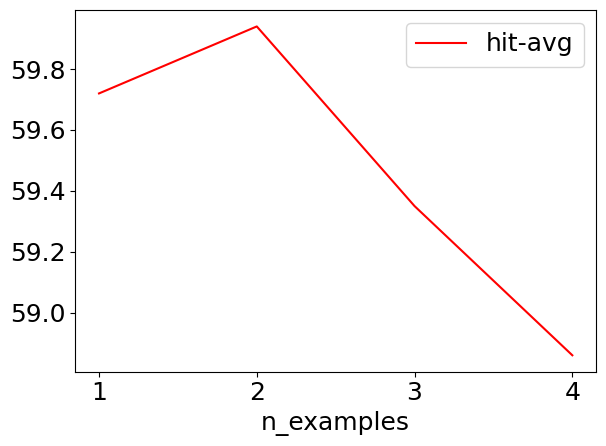

In [ ]:
xx = plot_selfref_horizons(data_df = df_hor_single, prefix = 'single', save_path = FIGURES_SAVE_PATH)

### Mixed setting

In [ ]:
df_hor_double = get_all_selfref_horizons_mixed()

In [ ]:
# df_hor_double

<Figure size 640x480 with 0 Axes>

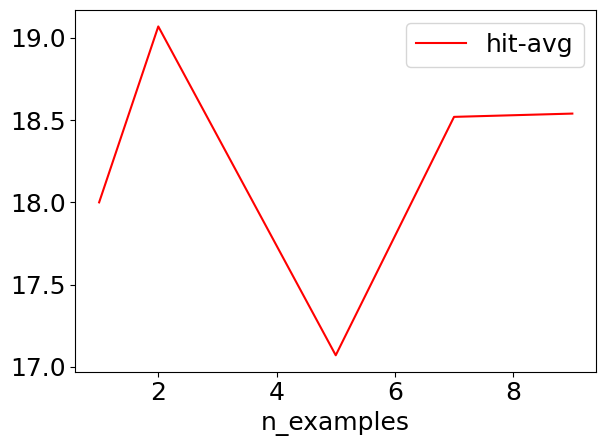

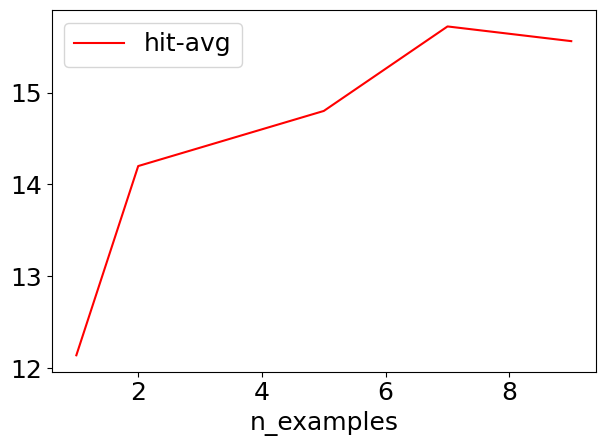

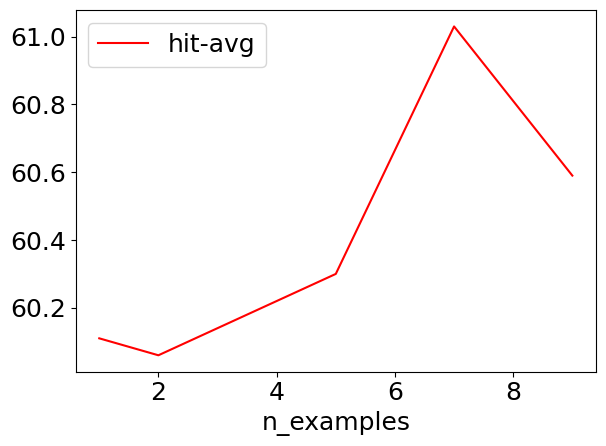

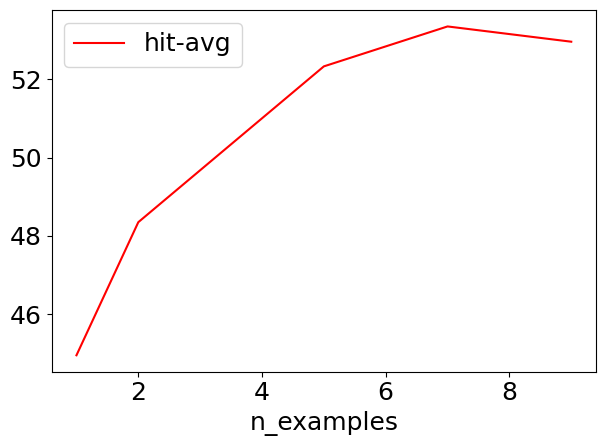

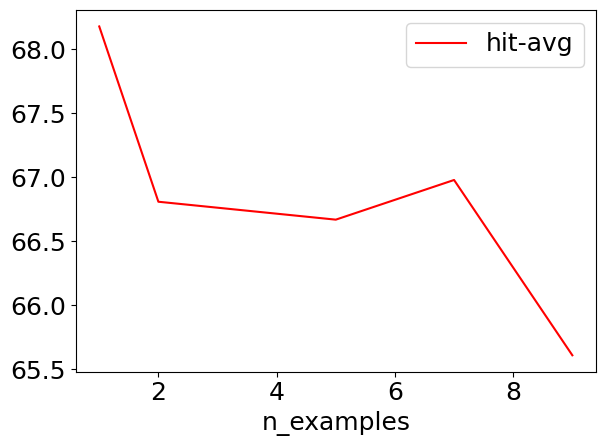

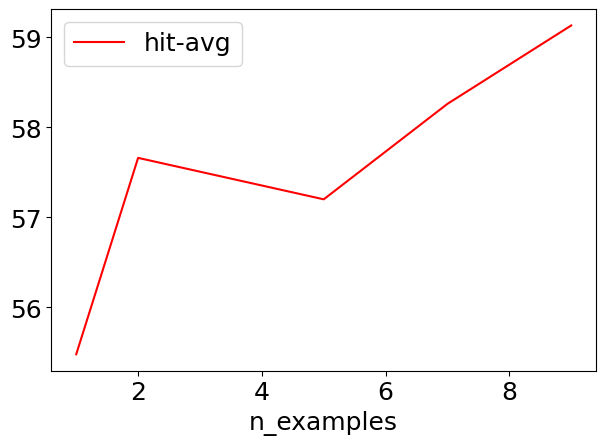

In [ ]:
xx = plot_selfref_horizons(data_df = df_hor_double, prefix = 'mixed', save_path = FIGURES_SAVE_PATH)

## Tests

In [ ]:
all_stats

,all_hits,cot,data_name,hint,model_name,agg_strategy,mixed_confidence,hits|conf:60,hits|conf:70,hits|conf:80,hits|conf:90,hits|conf:95,lconf_corr_n,lconf_corr_r,lconf_corr_p-val
0,0.909258,True,finqa,hint8,gpt-4o-mini,min_max,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.845494,True,finqa,hint8,gpt-4o-mini,mean,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.869099,True,finqa,hint8,gpt-4o-mini,lwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.335990,True,finqa,hint8,gpt-4o-mini,ilwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.843654,True,finqa,hint8,gpt-4o-mini,cwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.762391,False,medmcqa_medqa,hint8,gpt-3.5-turbo,cwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,0.953256,False,medmcqa_medqa,hint8,gpt-3.5-turbo,min_max,False,0.955296,0.950437,0.958698,0.954810,0.947036,10287.0,0.001309,0.894359
429,0.698056,False,medmcqa_medqa,hint8,gpt-3.5-turbo,mean,False,0.696307,0.695335,0.686589,0.704082,0.707969,10287.0,0.001206,0.902676
430,0.755394,False,medmcqa_medqa,hint8,gpt-3.5-turbo,lwm,False,0.743926,0.756074,0.752187,0.770165,0.754616,10290.0,0.001061,0.914298


In [ ]:
all_stats[(all_stats['hint'] == 'hint0') & (all_stats['cot'] == False)]

,all_hits,cot,data_name,hint,model_name,agg_strategy,mixed_confidence,hits|conf:60,hits|conf:70,hits|conf:80,hits|conf:90,hits|conf:95,lconf_corr_n,lconf_corr_r,lconf_corr_p-val
36,0.610975,False,finqa,hint0,gpt-4o-mini,min_max,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,0.192520,False,finqa,hint0,gpt-4o-mini,mean,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,0.214286,False,finqa,hint0,gpt-4o-mini,lwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,0.159718,False,finqa,hint0,gpt-4o-mini,ilwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,0.195586,False,finqa,hint0,gpt-4o-mini,cwm,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,0.448253,False,finqa,hint0,gpt-4o-mini,min_max,False,0.440834,0.426119,0.455855,0.453096,0.465359,16310.0,0.000687,0.930107
42,0.192459,False,finqa,hint0,gpt-4o-mini,mean,False,0.173513,0.170448,0.191600,0.199264,0.227468,16310.0,0.000090,0.990855
43,0.202452,False,finqa,hint0,gpt-4o-mini,lwm,False,0.180564,0.177805,0.201410,0.215819,0.236665,16310.0,0.000540,0.944973
44,0.164439,False,finqa,hint0,gpt-4o-mini,ilwm,False,0.154200,0.148069,0.164929,0.170448,0.184549,16310.0,-0.003892,0.619144
108,0.867995,False,mmlu,hint0,gpt-4o-mini,min_max,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# all_stats.to_dict('records')

In [ ]:
# all_stats.drop_duplicates(subset= ['all_hits', 'hits|conf:95', 'hits|conf:90', 'hits|conf:60', 'hits|conf:70', 'hits|conf:80', 'lconf_corr_n', 'lconf_corr_r', 'lconf_corr_p-val'])

In [ ]:
# all_stats

## Agg Tests

In [ ]:
data = upload_data(data_name = 'finqa', model_name = 'gpt-4o-mini', ci_explain = True, cot = True, rank = False)

In [ ]:
data_pro = process_data(df = data)

In [ ]:
data_pro.head()

,id,confidence_pct,conf_prompt_type,hint_type,try,data_name,model_name,ci_exaplain,cot,question,...,2. **lower_bound,3. **upper_bound,3. **setting lower bound**,4. **setting upper bound**,- **lower bound (lower_bound)**,- **upper bound (upper_bound)**,- a lower bound (`lower_bound`) that accounts for a conservative estimate,- an upper bound (`upper_bound`) that reflects a high-performing year,length,hit
0,0,95,both,hint8,0,finqa,gpt-4o-mini,True,True,what is the net change in net revenue during 2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,True
1,0,95,both,hint8,3,finqa,gpt-4o-mini,True,True,what is the net change in net revenue during 2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,False
2,0,95,both,hint3,3,finqa,gpt-4o-mini,True,True,what is the net change in net revenue during 2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,True
3,0,95,both,hint3,0,finqa,gpt-4o-mini,True,True,what is the net change in net revenue during 2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,False
4,0,95,both,hint8,1,finqa,gpt-4o-mini,True,True,what is the net change in net revenue during 2...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,False


In [ ]:
# data[data['hint_type'] == 'hint0']

In [ ]:
aggregate_responses(df = data_pro[data_pro['hint_type'] == 'hint0'], mixed_confidence = True, strategy = 'cwm')

<ipython-input-33-539f71fcd05d>:123: FutureWarning: The provided callable <function sum at 0x7e5e58dc7c40> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_res = grps.agg({"lower_bound": np.sum, "upper_bound": np.sum, 'answer': np.min}).reset_index()
<ipython-input-33-539f71fcd05d>:123: FutureWarning: The provided callable <function min at 0x7e5e58df44a0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  df_res = grps.agg({"lower_bound": np.sum, "upper_bound": np.sum, 'answer': np.min}).reset_index()


,id,lower_bound,upper_bound,answer
0,0,8.513866e+07,1.203831e+08,9.400000e+01
1,9,-5.944314e+06,2.020263e+07,-3.500000e+01
2,15,-1.967848e+01,7.502025e+01,3.298000e+03
3,16,1.849696e+02,7.393924e+02,6.500000e+01
4,17,1.456076e+02,5.673291e+02,7.042500e+02
...,...,...,...,...
3257,8259,1.094962e+02,1.401205e+06,6.274430e+08
3258,8262,1.912911e+01,5.279241e+01,1.030000e+01
3259,8266,-1.440000e+01,7.041772e+01,-1.600000e+01
3260,8269,9.267089e-01,1.343924e+00,1.600000e+00


## Other test

In [ ]:
import pandas as pd

# Example dataframe
data = {
    'Group': ['A', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'C'],
    'Value': [10, 20, 30, 10, 40, 50, 60, 70, 80],
}
df = pd.DataFrame(data)

# Calculate group mean and add as a new column
df['GroupMean'] = df.groupby('Group')['Value'].transform('mean')

print(df)

  Group  Value  GroupMean
0     A     10       20.0
1     A     20       20.0
2     A     30       20.0
3     B     10       25.0
4     B     40       25.0
5     C     50       65.0
6     C     60       65.0
7     C     70       65.0
8     C     80       65.0


## Other tests

In [ ]:
data = upload_data(data_name = 'finqa', model_name = 'gpt-4o-mini', ci_explain = True, cot = True, rank = False)

In [ ]:
data_pro = process_data(df = data)

In [ ]:
# data_pro

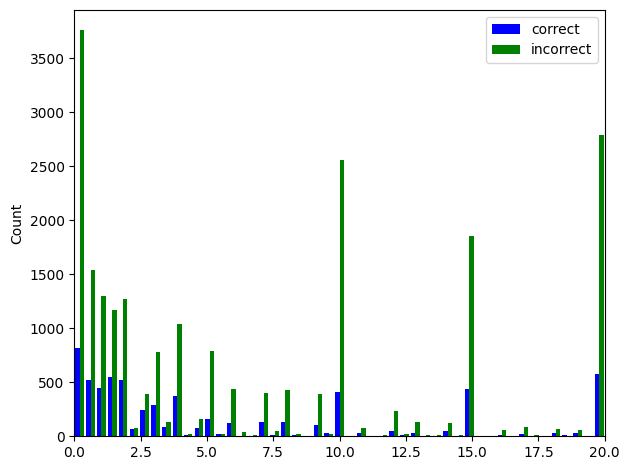

In [ ]:
length_vs_precision(df = data_pro[data_pro['hint_type'] == 'hint0'])

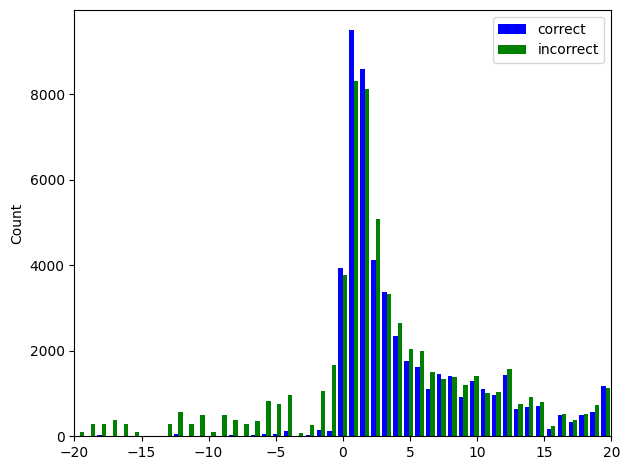

In [ ]:
scale_vs_precision(df = data_pro)

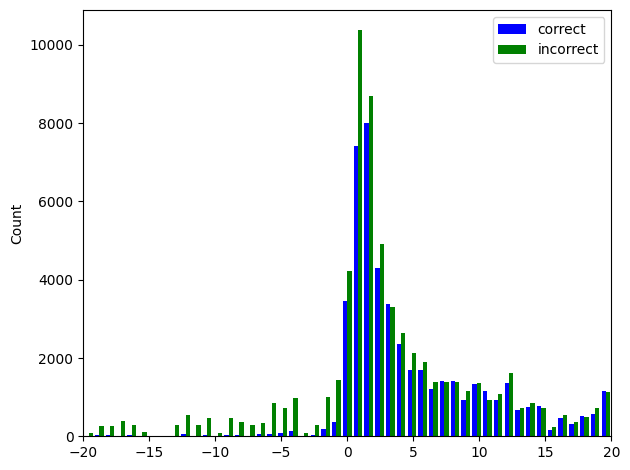

In [ ]:
scale_vs_precision(df = data_pro)

In [ ]:
length_vs_scale(df = data_pro)

{'len_scale_corr':               n         r        CI95%     p-val   BF10     power
 pearson  324031  0.000068  [-0.0, 0.0]  0.969185  0.002  0.050171}

## Tests

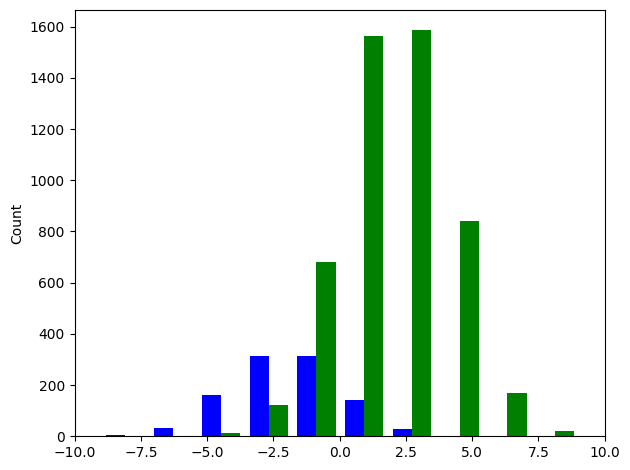

In [ ]:
#makes the data
y1 = np.random.normal(-2, 2, 1000)
y2 = np.random.normal(2, 2, 5000)
colors = ['b','g']

#plots the histogram
fig, ax1 = plt.subplots()
ax1.hist([y1,y2],color=colors)
ax1.set_xlim(-10,10)
ax1.set_ylabel("Count")
plt.tight_layout()
plt.show()